In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%run plotting_functions.ipynb

In [20]:
# !!! ONLY RUN THIS FUNCTION ON NON-MASKED DATA SETS !!!
def average_all_dfs(file_names):
    all_dfs = []
    n_sections = 0
    
    for n, file_name in enumerate(file_names):
        df = process_file(file_name)
        
        df = df.loc[:, (df != 0).any(axis=0)] # Remove columns containing only zeros
        
        n_sections += -(len(df.index) // -1440)
        all_dfs += [df]

    sections_array = np.zeros((1440, n_sections))
    i_section = 0

    for df in all_dfs:
        light_on_times = df.index[(df['Light'] == 1) & (df['Light'].shift(1) == 0)]
        
        spiders = df.drop(['Light', 'Day', 'Time'], axis=1)
        combined = spiders.mean(axis=1)

        for on_time in light_on_times:
            section = combined[on_time : on_time + 1440]
            sections_array[:len(section), i_section] = section
            
            i_section += 1

    average_all = sections_array[:, :i_section].mean(axis=1)

    result = pd.Series(average_all)
    
    return result

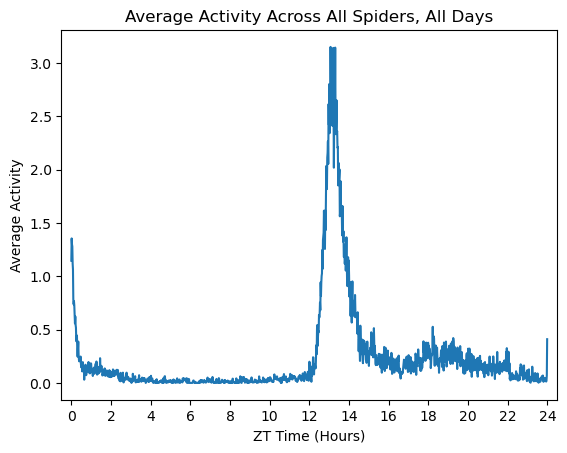

In [21]:
file_names = ['../Behavioral/Data/StA LD 1205-1212-2023.txt', '../Behavioral/Data/StA LD 1117-1128-2023.txt']

control_avg = average_all_dfs(file_names)

time = control_avg.index
plt.xlim(-.5, 24.5)
plt.xticks(range(0, 25, 2))
plt.xlabel('ZT Time (Hours)')
plt.ylabel('Average Activity')

plt.title('Average Activity Across All Spiders, All Days')

plt.plot(time / 60, control_avg)


In [22]:
def calculate_spider_activity(df, start_time, duration_mins=60):
    start_time = pd.to_datetime(start_time)
    end_time = start_time + pd.Timedelta(minutes=duration_mins)
    
    mask = (df['Time'] >= start_time) & (df['Time'] < end_time)
    df_filtered = df.loc[mask]
    
    spider_columns = [col for col in df.columns if col.startswith('Sp')]
    
    average_activity = df_filtered[spider_columns].mean()
    return average_activity

In [23]:
def get_first_lightson(df):
    lights = df['Light']
    light_on_times = df.index[(lights == 1) & (lights.shift(1) == 0)]
    return df['Time'][light_on_times[0]]

In [7]:
def get_masking_data(pulse_file, control_series, duration_mins=60):
    pulse_df = process_file(pulse_file)
    pulse_start = get_masking_bounds(pulse_df)[0]
    
    zt_start = get_first_lightson(pulse_df)

    pulse_start_zt_mins = int((pulse_start - zt_start).total_seconds() // 60) % 1440

    activities = calculate_spider_activity(pulse_df, pulse_start, duration_mins)

    control_avg = control_series[pulse_start_zt_mins : pulse_start_zt_mins + duration_mins].mean()

    return pulse_start_zt_mins, control_avg, activities

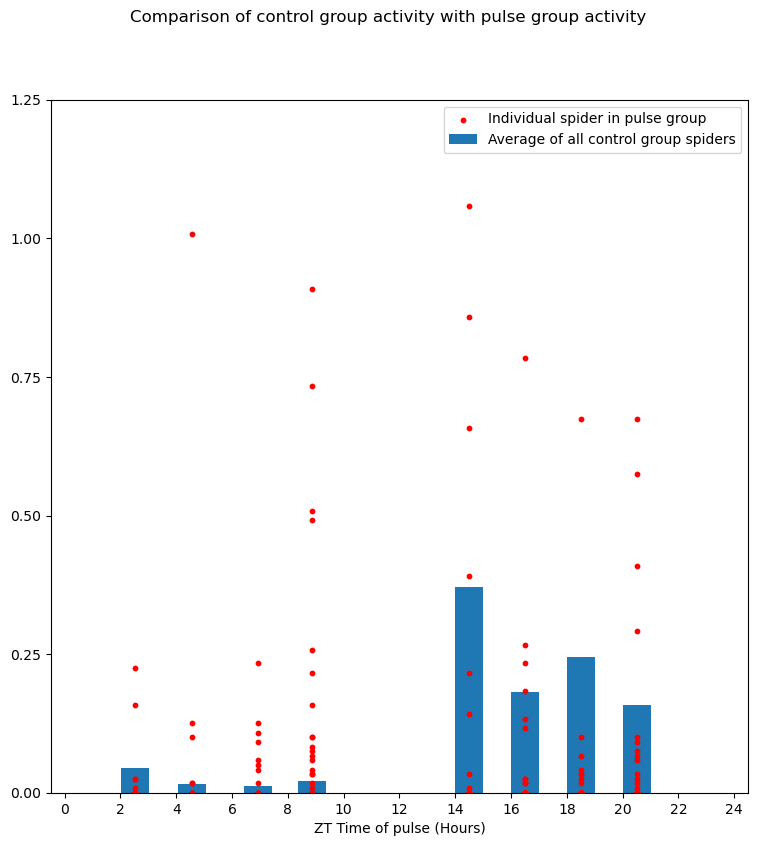

In [8]:
files = ['Steatoda A masking midnight.txt', 'Steatoda B maskng 2am.txt', 'Steatoda A masking 4 am.txt', 'Steatoda A masking 10 am - extra hour removed.txt', 'Steatoda B masking 12 pm.txt', 'Steatoda A masking 02 pm.txt', 'Steatoda B masking 04 pm.txt', 'Steatoda B masking 10 pm.txt']
         
nopulse_files = ['../Behavioral/Data/StA LD 1205-1212-2023.txt', '../Behavioral/Data/StA LD 1117-1128-2023.txt']

control_series = average_all_dfs(nopulse_files)

times = []
controls = []
scatters = []

for n, file in enumerate(files):
    time, control_avg, activities = get_masking_data(file, control_series, duration_mins=120)

    times.append(time / 60 + .5)
    controls.append(control_avg)
    scatters.append(activities)

fig, ax = plt.subplots()

ax.set_xticks(range(0, 25, 2))
ax.set_yticks(np.arange(0, 5, .25))
ax.set_xlabel('ZT Time of pulse (Hours)')

ax.set_xlim(-.5, 24.5)
ax.set_ylim(0, 1.25)

bargraph = ax.bar(times, controls, width=1, label='Average of all control group spiders')
_ = ax.scatter(None, None, color='red', s=10, label='Individual spider in pulse group')

for (time, points) in zip(times, scatters):
    ax.scatter([time for _ in points], points, color='red', s=10)

fig.suptitle('Comparison of control group activity with pulse group activity')
ax.legend()
fig.set_size_inches(9, 9)

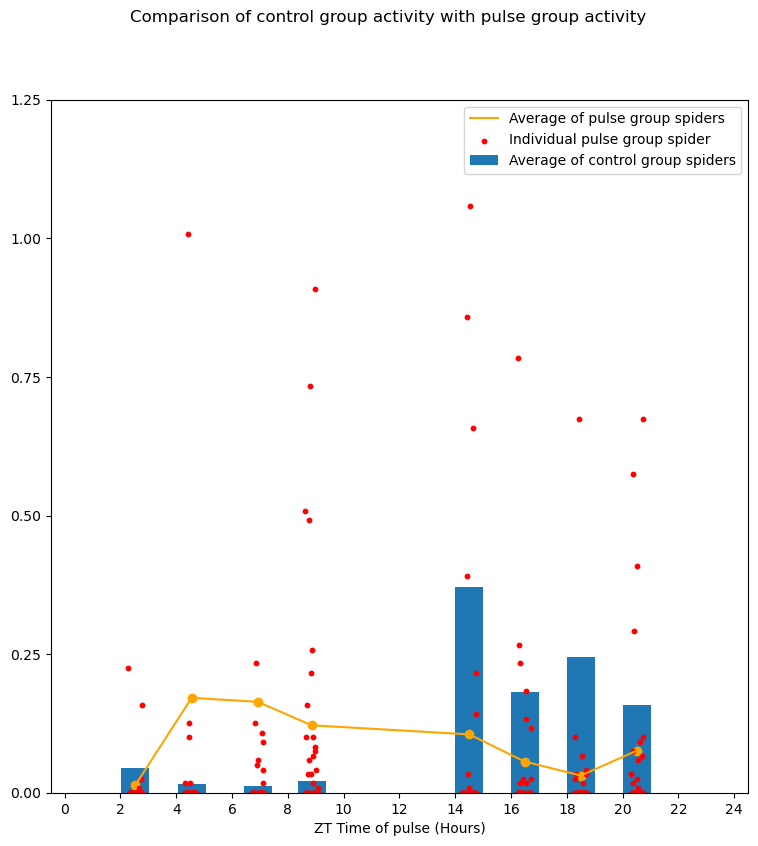

In [9]:
files = ['Steatoda A masking midnight.txt', 'Steatoda B maskng 2am.txt', 'Steatoda A masking 4 am.txt', 'Steatoda A masking 10 am - extra hour removed.txt', 'Steatoda B masking 12 pm.txt', 'Steatoda A masking 02 pm.txt', 'Steatoda B masking 04 pm.txt', 'Steatoda B masking 10 pm.txt']
         
nopulse_files = ['../Behavioral/Data/StA LD 1205-1212-2023.txt', '../Behavioral/Data/StA LD 1117-1128-2023.txt']

control_series = average_all_dfs(nopulse_files)

times = []
controls = []
scatters = []

for n, file in enumerate(files):
    time, control_avg, activities = get_masking_data(file, control_series, duration_mins=120)

    times.append(time / 60 + .5)
    controls.append(control_avg)
    scatters.append(activities)

times, controls, scatters = zip(*sorted(list(zip(times, controls, scatters))))

fig, ax = plt.subplots()

ax.set_xticks(range(0, 25, 2))
ax.set_yticks(np.arange(0, 5, .25))
ax.set_xlabel('ZT Time of pulse (Hours)')

ax.set_xlim(-.5, 24.5)
ax.set_ylim(0, 1.25)

ax.bar(times, controls, width=1, label='Average of control group spiders')
ax.scatter(times, [pts.mean() for pts in scatters], color='orange')
ax.plot(times, [pts.mean() for pts in scatters], color='orange', label='Average of pulse group spiders')

ax.scatter(None, None, color='red', s=10, label='Individual pulse group spider')

for (time, points) in zip(times, scatters):
    ax.scatter(time + .5 * np.random.rand(len(points)) - .25, points, color='red', s=10)

fig.suptitle('Comparison of control group activity with pulse group activity')
ax.legend()
fig.set_size_inches(9, 9)

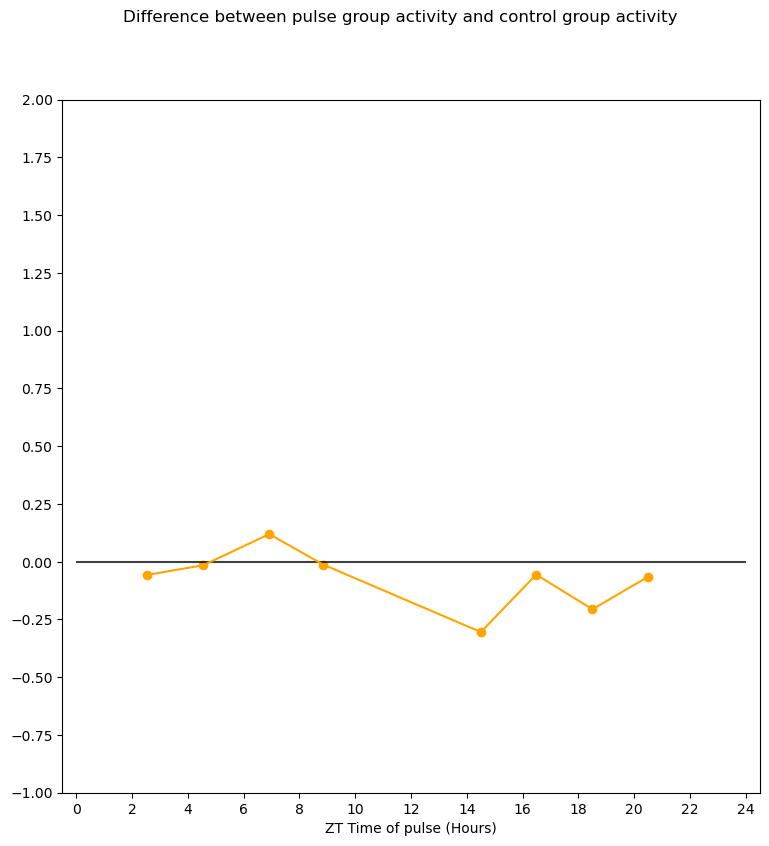

In [10]:
times = []
controls = []
scatters = []

for n, file in enumerate(files):
    time, control_avg, activities = get_masking_data(file, control_series, duration_mins=60)

    times.append(time / 60 + .5)
    controls.append(control_avg)
    scatters.append(activities)

times, controls, scatters = zip(*sorted(list(zip(times, controls, scatters))))

fig, ax = plt.subplots()

ax.set_xticks(range(0, 25, 2))
ax.set_yticks(np.arange(-5, 5, .25))
ax.set_xlabel('ZT Time of pulse (Hours)')

ax.set_xlim(-.5, 24.5)
ax.set_ylim(-1, 2)

ax.hlines(0, 0, 24, color='black', alpha=.75)

ax.scatter(times, [pts.mean() - control for pts, control in zip(scatters, controls)], color='orange')
ax.plot(times, [pts.mean() - control for pts, control in zip(scatters, controls)], color='orange')

fig.suptitle('Difference between pulse group activity and control group activity')
fig.set_size_inches(9, 9)

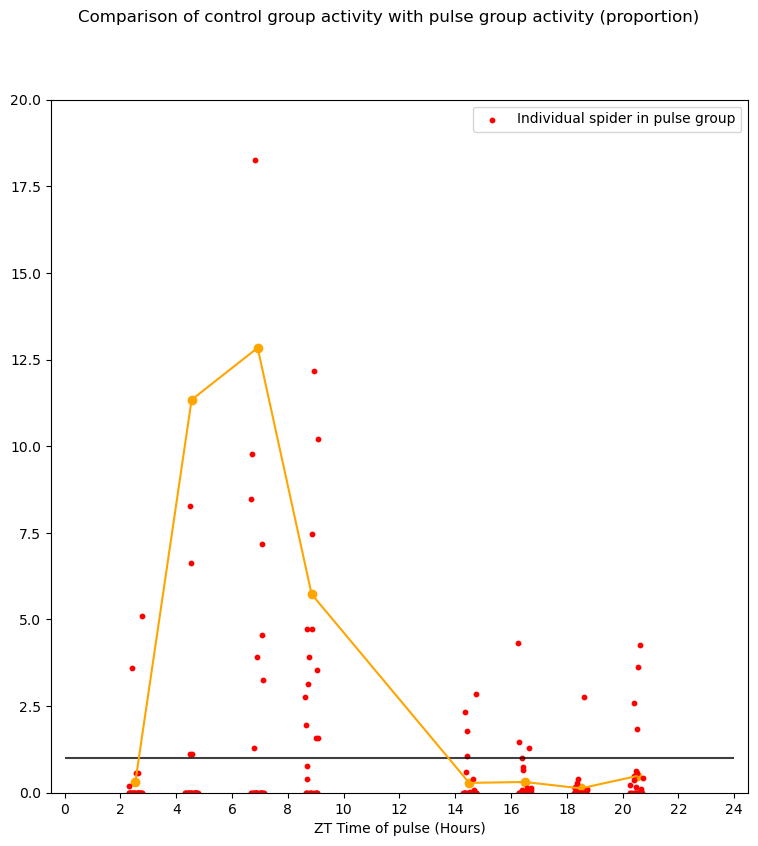

In [11]:
times = []
controls = []
scatters = []

for n, file in enumerate(files):
    time, control_avg, activities = get_masking_data(file, control_series, duration_mins=120)

    times.append(time / 60 + .5)
    controls.append(control_avg)
    scatters.append(activities)

times, controls, scatters = zip(*sorted(list(zip(times, controls, scatters))))

fig, ax = plt.subplots()

ax.set_xticks(range(0, 25, 2))
ax.set_xlabel('ZT Time of pulse (Hours)')

ax.set_xlim(-.5, 24.5)
ax.set_ylim(0, 20)

ax.hlines(1, 0, 24, color='black', alpha=.75)
ax.scatter(times, [pts.mean() / control for pts, control in zip(scatters, controls)], color='orange')
ax.plot(times, [pts.mean() / control for pts, control in zip(scatters, controls)], color='orange')

ax.scatter(None, None, color='red', s=10, label='Individual spider in pulse group')

for (time, points, control) in zip(times, scatters, controls):
    ax.scatter(time + .5 * np.random.rand(len(points)) - .25, points / control, color='red', s=10)

fig.suptitle('Comparison of control group activity with pulse group activity (proportion)')
ax.legend()
fig.set_size_inches(9, 9)

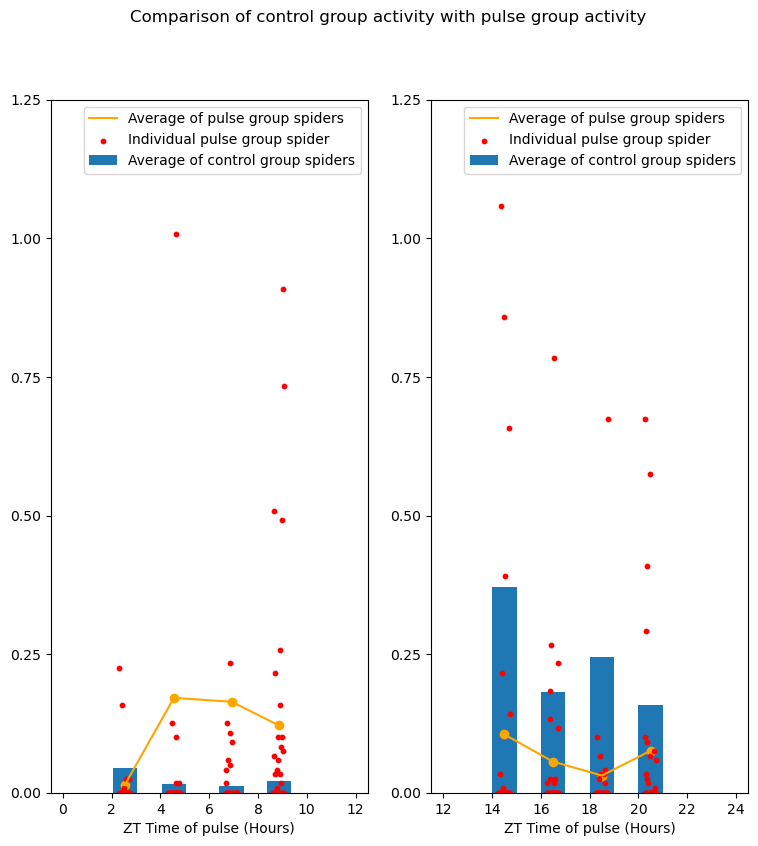

In [12]:
timesl = ([], [])
controlsl = ([], [])
scattersl = ([], [])

for n, file in enumerate(files):
    time, control_avg, activities = get_masking_data(file, control_series, duration_mins=120)
    if (time / 60 < 12):
        timesl[0].append(time / 60 + .5)
        controlsl[0].append(control_avg)
        scattersl[0].append(activities)
    else:
        timesl[1].append(time / 60 + .5)
        controlsl[1].append(control_avg)
        scattersl[1].append(activities)

times, controls, scatters = zip(*sorted(list(zip(times, controls, scatters))))

fig, axs = plt.subplots(1, 2)


for n in [0, 1]:
    times, controls, scatters = zip(*sorted(list(zip(timesl[n], controlsl[n], scattersl[n]))))
    
    axs[n].set_xticks(range(0, 25, 2))
    axs[n].set_yticks(np.arange(0, 5, .25))
    axs[n].set_xlabel('ZT Time of pulse (Hours)')
    
    axs[n].set_xlim(-.5, 24.5)
    axs[n].set_ylim(0, 1.25)

    if n == 0:
        axs[n].set_xlim(-.5, 12.5)
    if n == 1:
        axs[n].set_xlim(11.5, 24.5)
    
    axs[n].bar(times, controls, width=1, label='Average of control group spiders')
    axs[n].scatter(times, [pts.mean() for pts in scatters], color='orange')
    axs[n].plot(times, [pts.mean() for pts in scatters], color='orange', label='Average of pulse group spiders')
    
    axs[n].scatter(None, None, color='red', s=10, label='Individual pulse group spider')

    for (time, points) in zip(times, scatters):
        axs[n].scatter(time + .5 * np.random.rand(len(points)) - .25, points, color='red', s=10)

    axs[n].legend()

fig.suptitle('Comparison of control group activity with pulse group activity')
fig.set_size_inches(9, 9)

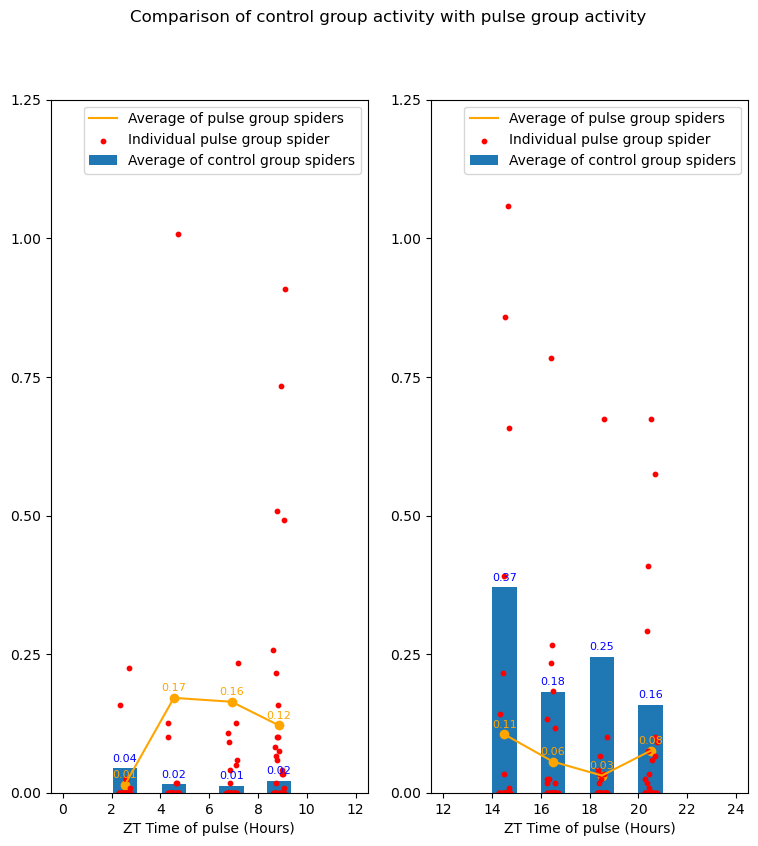

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming get_masking_data is defined elsewhere
# files and control_series should be defined and populated with appropriate values

timesl = ([], [])
controlsl = ([], [])
scattersl = ([], [])

for n, file in enumerate(files):
    time, control_avg, activities = get_masking_data(file, control_series, duration_mins=120)
    if (time / 60 < 12):
        timesl[0].append(time / 60 + .5)
        controlsl[0].append(control_avg)
        scattersl[0].append(activities)
    else:
        timesl[1].append(time / 60 + .5)
        controlsl[1].append(control_avg)
        scattersl[1].append(activities)

fig, axs = plt.subplots(1, 2)

for n in [0, 1]:
    times, controls, scatters = zip(*sorted(list(zip(timesl[n], controlsl[n], scattersl[n]))))
    
    axs[n].set_xticks(range(0, 25, 2))
    axs[n].set_yticks(np.arange(0, 5, .25))
    axs[n].set_xlabel('ZT Time of pulse (Hours)')
    
    axs[n].set_xlim(-.5, 24.5)
    axs[n].set_ylim(0, 1.25)

    if n == 0:
        axs[n].set_xlim(-.5, 12.5)
    if n == 1:
        axs[n].set_xlim(11.5, 24.5)
    
    # Plot the bar for control group
    axs[n].bar(times, controls, width=1, label='Average of control group spiders')
    
    # Plot the scatter and line for pulse group
    pulse_means = [pts.mean() for pts in scatters]
    axs[n].scatter(times, pulse_means, color='orange')
    axs[n].plot(times, pulse_means, color='orange', label='Average of pulse group spiders')
    
    # Scatter individual points
    axs[n].scatter(None, None, color='red', s=10, label='Individual pulse group spider')
    for (time, points) in zip(times, scatters):
        axs[n].scatter(time + .5 * np.random.rand(len(points)) - .25, points, color='red', s=10)
    
    # Annotate the average points
    for time, control, pulse_mean in zip(times, controls, pulse_means):
        axs[n].annotate(f'{control:.2f}', (time, control), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='blue')
        axs[n].annotate(f'{pulse_mean:.2f}', (time, pulse_mean), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='orange')
    
    axs[n].legend()

fig.suptitle('Comparison of control group activity with pulse group activity')
fig.set_size_inches(9, 9)
plt.show()

In [2]:
from scipy.optimize import curve_fit

timesl = ([], [])
controlsl = ([], [])
scattersl = ([], [])

for n, file in enumerate(files):
    time, control_avg, activities = get_masking_data(file, control_series, duration_mins=120)
    if (time / 60 < 12):
        timesl[0].append(time / 60 + .5)
        controlsl[0].append(control_avg)
        scattersl[0].append(activities)
    else:
        timesl[1].append(time / 60 + .5)
        controlsl[1].append(control_avg)
        scattersl[1].append(activities)

times, controls, scatters = zip(*sorted(list(zip(times, controls, scatters))))

fig, axs = plt.subplots(1, 2)

def quadratic(x, a, b, c):
    return a*(x**2) + b*x + c

for n in [0, 1]:
    times, controls, scatters = zip(*sorted(list(zip(timesl[n], controlsl[n], scattersl[n]))))
    
    axs[n].set_xticks(range(0, 25, 2))
    axs[n].set_yticks(np.arange(0, 5, .25))
    axs[n].set_xlabel('ZT Time of pulse (Hours)')
    
    axs[n].set_xlim(-.5, 24.5)
    axs[n].set_ylim(0, 1.25)

    scatters_flat = []
    scatter_times = []
    for time, scatter in zip(times, scatters):
        scatters_flat += list(scatter)
        scatter_times += [time for _ in scatter]

    if n == 0:
        axs[n].set_xlim(-.5, 12.5)
    if n == 1:
        axs[n].set_xlim(11.5, 24.5)
    
    axs[n].bar(times, controls, width=1, label='Average of control group spiders')
    axs[n].scatter(times, [pts.mean() for pts in scatters], color='orange')
    axs[n].plot(times, [pts.mean() for pts in scatters], color='orange', label='Average of pulse group spiders')
    
    axs[n].scatter(scatter_times, scatters_flat, color='red', s=10, label='Individual pulse group spider')

    opt, cov = curve_fit(quadratic, scatter_times, scatters_flat)

    curve_x = np.arange(2+12*n, 10+12*n, .1)
    curve_y = quadratic(curve_x, *opt)

    print(opt)

    axs[n].plot(curve_x, curve_y, color='lime')
    
    axs[n].legend()

fig.suptitle('Comparison of control group activity with pulse group activity')
fig.set_size_inches(9, 9)



NameError: name 'files' is not defined

[ 0.16197293  0.1289975  -0.0369093 ]
[ 0.16197294  0.12899783 -0.03690928]


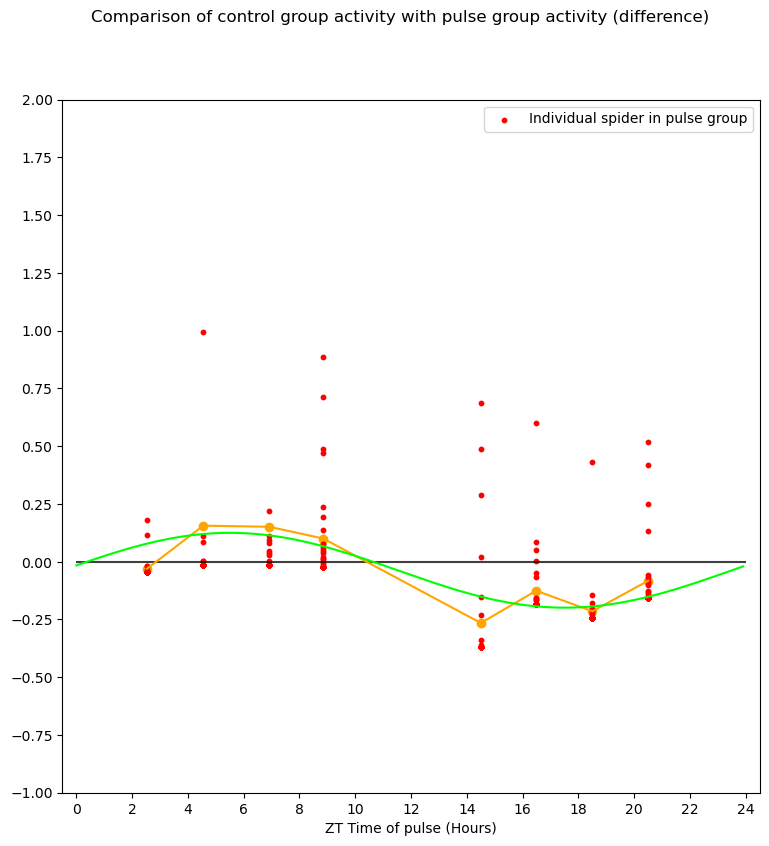

In [53]:
times = []
controls = []
scatters = []

for n, file in enumerate(files):
    time, control_avg, activities = get_masking_data(file, control_series, duration_mins=120)

    times.append(time / 60 + .5)
    controls.append(control_avg)
    scatters.append(activities)

times, controls, scatters = zip(*sorted(list(zip(times, controls, scatters))))

scatters_flat = []
scatter_times = []
for time, scatter, control in zip(times, scatters, controls):
    scatters_flat += list(scatter - control)
    scatter_times += [time for _ in scatter]

def sinusoid(x, a, b, c):
    return a*np.sin(x * .2618 + b) + c

fig, ax = plt.subplots()

ax.set_xticks(range(0, 25, 2))
ax.set_yticks(np.arange(-5, 5, .25))
ax.set_xlabel('ZT Time of pulse (Hours)')

ax.set_xlim(-.5, 24.5)
ax.set_ylim(-1, 2)

ax.hlines(0, 0, 24, color='black', alpha=.75)

means = [pts.mean() - control for pts, control in zip(scatters, controls)]
ax.scatter(times, means, color='orange')
ax.plot(times, means, color='orange')

ax.scatter(scatter_times, scatters_flat, color='red', s=10, label='Individual spider in pulse group')

opt, cov = curve_fit(sinusoid, scatter_times, scatters_flat)
opt2, cov2 = curve_fit(sinusoid, times, means)

print(opt)
print(opt2)

curve_x = np.arange(0, 24, .1)
curve_y = sinusoid(curve_x, *opt)

ax.plot(curve_x, curve_y, color='lime')

fig.suptitle('Comparison of control group activity with pulse group activity (difference)')
ax.legend()
fig.set_size_inches(9, 9)

File-wise data:

File: Steatoda A masking midnight.txt
Time (ZT Hours): 16.483333333333334
Control Average: 0.18175689223057645
Activity: Sp1     0.000000
Sp2     0.000000
Sp3     0.233333
Sp4     0.016667
Sp5     0.000000
Sp6     0.000000
Sp7     0.000000
Sp8     0.000000
Sp9     0.133333
Sp10    0.000000
Sp11    0.783333
Sp12    0.000000
Sp13    0.000000
Sp14    0.025000
Sp15    0.000000
Sp16    0.025000
Sp17    0.016667
Sp18    0.000000
Sp19    0.266667
Sp20    0.000000
Sp21    0.000000
Sp22    0.183333
Sp23    0.000000
Sp24    0.000000
Sp25    0.116667
Sp26    0.000000
Sp27    0.000000
Sp28    0.000000
Sp29    0.000000
Sp30    0.000000
Sp31    0.000000
Sp32    0.000000
dtype: float64
T-statistic: -4.708845363957206
P-value: 4.939706266535635e-05
Reject Null Hypothesis

File: Steatoda B maskng 2am.txt
Time (ZT Hours): 18.5
Control Average: 0.2453416875522139
Activity: Sp1     0.033333
Sp2     0.000000
Sp3     0.000000
Sp4     0.041667
Sp5     0.066667
Sp6     0.000000
Sp7     0.0250

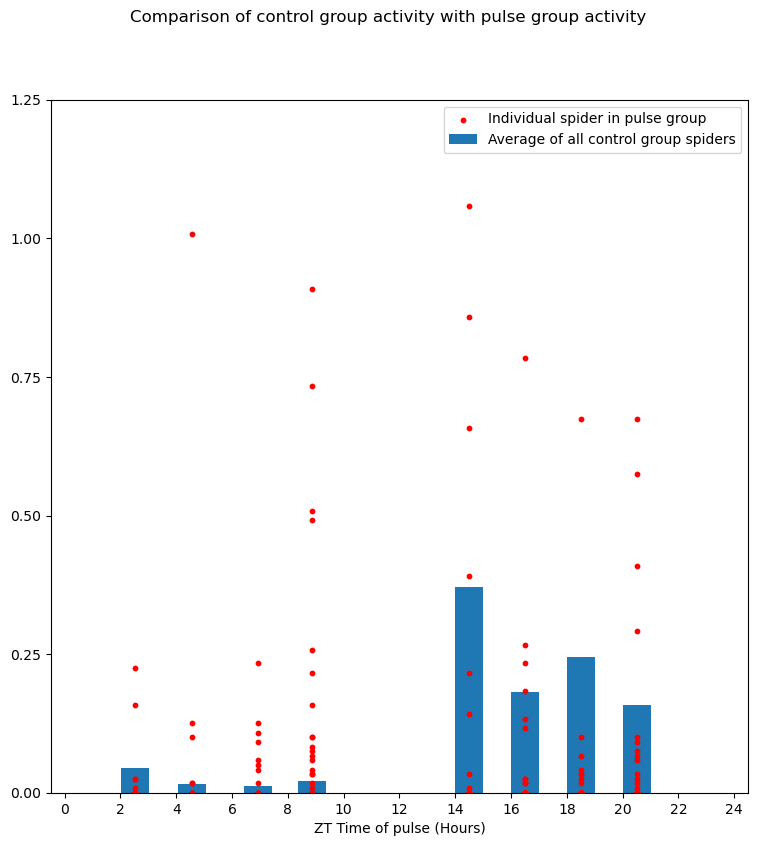

In [23]:
from scipy.stats import ttest_1samp
import numpy as np

files = ['Steatoda A masking midnight.txt', 'Steatoda B maskng 2am.txt', 'Steatoda A masking 4 am.txt', 'Steatoda A masking 10 am - extra hour removed.txt', 'Steatoda B masking 12 pm.txt', 'Steatoda A masking 02 pm.txt', 'Steatoda B masking 04 pm.txt', 'Steatoda B masking 10 pm.txt']
         
nopulse_files = ['../Behavioral/Data/StA LD 1205-1212-2023.txt', '../Behavioral/Data/StA LD 1117-1128-2023.txt']

control_series = average_all_dfs(nopulse_files)

times = []
controls = []
scatters = []

for n, file in enumerate(files):
    time, control_avg, activities = get_masking_data(file, control_series, duration_mins=120)

    times.append(time / 60 + .5)
    controls.append(control_avg)
    scatters.append(activities)

fig, ax = plt.subplots()

ax.set_xticks(range(0, 25, 2))
ax.set_yticks(np.arange(0, 5, .25))
ax.set_xlabel('ZT Time of pulse (Hours)')

ax.set_xlim(-.5, 24.5)
ax.set_ylim(0, 1.25)

bargraph = ax.bar(times, controls, width=1, label='Average of all control group spiders')
_ = ax.scatter(None, None, color='red', s=10, label='Individual spider in pulse group')

for (time, points) in zip(times, scatters):
    ax.scatter([time for _ in points], points, color='red', s=10)

fig.suptitle('Comparison of control group activity with pulse group activity')
ax.legend()
fig.set_size_inches(9, 9)

print("File-wise data:")
for file in files:
    time, control_avg, activities = get_masking_data(file, control_series, duration_mins=120)

    times.append(time / 60 + .5)
    controls.append(control_avg)
    scatters.append(activities)
    
    print(f"\nFile: {file}")
    print(f"Time (ZT Hours): {time / 60 + .5}")
    print(f"Control Average: {control_avg}")
    print(f"Activity: {activities}")

    # Ensure activity is a numpy array of numerical values
    activity_array = np.array(activities)

#ONE SAMPLE T-TEST
    try:
        t_statistic, p_value = ttest_1samp(activity_array, control_avg)

        print(f"T-statistic: {t_statistic}")
        print(f"P-value: {p_value}")

        # Interpret the results
        if p_value < 0.05:
            print('Reject Null Hypothesis')
        else:
            print('Fail to Reject Null Hypothesis')
    except Exception as e:
        print(f"Error performing t-test: {e}")